# Processing of particle tracks 
### <font color='gray'>coded to work with experiments and simulation</font>

## _Import of python libraries used within the code_

### <font color ='gray'> load both code cells  </font>

In [215]:
import numpy as np # fast array library
import pandas as pd # data frames library
# plot display type. use this to keep graphs within the notebook
%matplotlib inline 
# %matplotlib tk # this one displays plots into separate windows. it's best for saving to PDF/EPS
import matplotlib.pyplot as plt # plot library

import subprocess # these 2 lines below load OS functionality
import sys
import json

from IPython.display import display, HTML # screen on display in HTML library 

import sympy as sp # symbolic calculation library functions
from sympy import var # symbolic calculation library variables

import mpmath as mp # double (or higher) floating point precision library (not used)

import scipy.constants as ct # import mathematical constants
import scipy.stats as st
import scipy.special as spec

import ipywidgets as widgets # import 

from scipy.spatial import Voronoi, voronoi_plot_2d # import Voronoi functions

import scipy.optimize as optimize # optimazation library (not used)
from collections import Counter # (not used)
import time # timing functions (for computation time)

from scipy import signal # noise filtering functions

# system size for a given (npart, rho) configuration
def L(npart, rho):
    l = np.sqrt(npart*2*np.sqrt(3.)/rho)
    return l

# print progress function
# more elegant (python 3 alternative): print('\rhello', end='',flush=True)
def printp(string):
    sys.stdout.write('\r'+ str(string))
    sys.stdout.flush()
    
#from __future__ import print_function

# Text format for figures configuration (lines below)
from matplotlib import rc
rc('text', usetex=True)
plt.rcParams['font.size'] = 14
# special plotting functions
from matplotlib.collections import PolyCollection
import matplotlib.colors as mcolors


In [2]:
def progreso(val,vmax):

    a= widgets.IntProgress(
        value=val,
        min=0,
        max=vmax,
        step=1,
        description='Loading:',
        bar_style='', # 'success', 'info', 'warning', 'danger' or ''
        orientation='horizontal'
    )
    return a

In [3]:
progreso(2,104)

## _Read tracking data _ 

We explain the action of each of these functions below:

__get_info(hash_prefix) :__ Reads and prints info file with  _hash prefix_ hash code. See output table in <font color='red' >RUN CELL 0</font> below to grasp the info structure

__simple_pickle_read(hash_prefix) :__
This 'simple_pickle_read' takes a pkl.xz file _hash prefix_ hash code, and which contains xy positions and tracks (no velocities) and stores in 'tabla' pandas data frame.
   
  * input: hash_prefix
  * output: global variable _Ntracks_ (number of tracks) 

In [2]:
# This function reads pickle binary file (.pkl) with trajectories
def get_info(series_directory, hash_prefix):
    global info
    nombre = './Datos/'+ series_directory +'/info/' + hash_prefix + '.txt'
    with open(nombre) as f:
        jsonstr = json.load(f)
    info = pd.io.json.json_normalize(jsonstr)
    display(HTML(info.T.to_html()))
    return info

def simple_pickle_read(series_directory, hash_prefix):
    global Nframes, Ntracks
    # Read table in pickle format
    nombre = './Datos/' + series_directory + '/tracks/' + hash_prefix + '.pkl.xz'
    tabla = pd.read_pickle(nombre, compression='infer')
    tabla = tabla.reset_index(drop=True) # por si los indices salen desordenados
    Nframes = np.max(tabla.frame)+1
    Ntracks = np.max(tabla.track)+1
    print('Number of frames in the movie: ', Nframes)
    print('Maximum track index: ', Ntracks)
    print('\nFirst 5 rows of imported table:\n')
    display(HTML(tabla.head().to_html()))
    tabla = tabla.sort_values(by = ['frame', 'track']).reset_index(drop=True)
    return tabla

In [25]:
%matplotlib --list 

Available matplotlib backends: ['osx', 'inline', 'tk', 'gtk3', 'qt5', 'qt4', 'qt', 'nbagg', 'notebook', 'gtk', 'wx']


## _Reduce global table - functions _ 

__reset_track_indexes(tabla0):__ 
Eliminates 'lonely' tracks (particles tracked for just 1 frame), re-indexes so that no track indexes are empty
* input: _tabla0_ original data frame (of tracks)
* output: RETURNS clean _tabla_ data frame, without empty tracks; AND original _tabla0_ with empty tracks still included
* output structure: _tabla0_, _tabla_

__short_drop:(ishort, tabla):__ 
Eliminates tracks detected for n frames or less, re-indexes so that no track indexes are empty

* Input: _ishort_ (threshold length of tracks: shorter tracks are not kept), _tabla_ (original tracks data frame)

* Output: RETURNS _tabla_\__short_ (frame), that is the input table _tabla_ without tracks shorter than _ishort_


In [3]:
def reset_track_indexes(tabla0):
    global Ntracks, Nframes
    """ This function takes a dataframe in which some trajectory indexes
        are missing (maybe due to having deleted short trajectories) and
        resets indexes so that we can loop over the tracks with 'range' """
    # 'real_number_of_tracks' should be <=  than 'current_last_particle_index'
    tabla = tabla0.copy()
    Ntracks = len(set(tabla.track))
    original_indexes = np.sort(list(set(tabla.track)))
    unsort_indexes = original_indexes
    fixed_indexes = np.arange(0, Ntracks, step=1, dtype=int)
    if  (original_indexes == fixed_indexes).all()==False: # fix only if there are empty tracks
    # With these two lists we create a dictionary and map old values to new ones
        n_empty = np.max(tabla.track) - Ntracks
        replacement_dict = dict(zip(original_indexes, fixed_indexes))
        tabla.track = tabla.track.map(dict(zip(original_indexes, fixed_indexes)))
        print('no. of empty track indexes discarded: ', n_empty, '\n')
    else:
        print('nothing to fix\n')
    Ntracks = np.max(tabla.track)+1
    Nframes = np.max(tabla.frame)+1
    return tabla0, tabla

# INPUT
# ishort: number of minimum frames in a track (eliminates tracks under ishort time length)
# tabla: pandas Data Frame to shorten
# OUTPUT
def short_drop(ishort, tabla):
    global shorts_list, Ntracks
    shorts_list =[]
    Ntracks = np.max(tabla.track)+1
    for i in range(Ntracks):
        t1 = track(i,tabla,False)
        if  0 < len(t1) < ishort+1:
            shorts_list.append(i)
            len0 = len(tabla)
            tabla = tabla.drop(t1['index'])
            texto = 'dropped track no. '+str(i)+'; data table length decreased in '+str(len(tabla)-len0)
            printp(texto)
    tabla_short = tabla.sort_values(by = ['frame', 'track']).reset_index(drop=True)
    Nshorts = np.max(tabla_short.track)+1
    printp('Dropped out ' + str(Ntracks-Nshorts)+' short tracks out of '+ str(Ntracks))
    # the line above is necessary so that eliminates index voids and shuffling after short drop
    print('\n')
    return tabla_short



## _Get tracks and states from global table - functions _ 

__track(t_id, tabla, dropit) :__  builds track for one particle from the appropriate chunk of the source table, with only the lines for particle _t_\__id_ 

* Input: _t_\__id_ indice de track, _tabla_ source frame fuente (contains tracks), _dropit_ boolean; if =True then erases old index column (tracks do not always begin in frame 0); most of the time you just want _dropit_=True

* Output: RETURNS a chunk of source table _tabla_ with only the lines for particle _t_\__id_

__all\___ __tracks(tabla, dropit):__ repeats the process in _track_ function for all existing particles

* Input: _tabla_ (frame) data source, _dropit_ boolean variable set True to erase original table original line number

* Output: RETURNS _track_ array of frames each wiith one particle track; builds _tr_\__lengths_ array of tracks lengths


__state(it, tabla):__ gets one instantaneous state frome source frame _tabla_, at frame _it_

* Input: _it_ frame no. to get the state from; _tabla_ source frame data

* Output: RETURNS st frame chunk from _tabla_ source frame

__all__\___states(tabla):__ Builds all instantaneous states from the movie

* Input: _tabla_ source frame data

* Output: RETURNS array of frame chunks from _tabla_ source frame. each chunk being an instantaneous state

In [4]:
#####  INDIVIDUAL TRACKS ##############
# build a 't_id' indivitual track 
def track(t_id, tabla, dropit):
    t1 = tabla.loc[tabla.track == t_id].reset_index(drop=dropit)
    return t1

# build individual tracks from all kept tracks
# OUTPUT
# tr_lengths[i]: length of track no.  'i'. The total no. of tracks is stored in 'Ntracks'
def all_tracks(tabla,dropit):
    # length of track
    global tr_lengths
    tr_lengths = np.empty(Ntracks,dtype=int)
    tracks = [[] for i in range(Ntracks)]
    for i in range(Ntracks):
        tracks[i] = track(i,tabla,dropit)
        tr_lengths[i] = int(len(tracks[i]))
    return tracks

#####  INSTANTANEOUS STATES  ##############
# BUILD INSTANTANEOUS STATES OF THE SYSTEM
def state(it, tabla):
    st = tabla.loc[tabla.frame == it].reset_index(drop=True)
    # reset row index 
    #(otherwise keeps chunked index of the original table)
    return st

# build instantaneous states over all frames
def all_states(tabla):
    sts = [[] for i in range(Nframes)]
    for i in range(Nframes):
        sts[i] = state(i,tabla)
    return sts

## _Get velocities from tracks _ 

__vels(tabla) :__ Ouputs velocities from tracks table

* Input: _tabla_ frame data source

* Output: RETURNS _tabla_ with 2 new columns (_tabla['vx']_, _tabla['vy']_)

In [5]:
def vels(tabla):
    tabla['vx'] = np.zeros(len(tabla))
    tabla['vy'] = np.zeros(len(tabla))
    for k in range(Ntracks):
        if len(tabla[tabla.track==k])>1:
            t1 = track(k, tabla, False)
            printp('diffs: ' + str(k+1)+ ' of ' + str(Ntracks) + ' tracks')
            tabla.loc[t1['index'][:-1],'vx'] = np.diff(t1.x) 
            tabla.loc[t1['index'][:-1],'vy'] = np.diff(t1.y)
            # the line below drops rows of the last track position (since they have no v)
            tabla = tabla.drop(tabla.loc[tabla.track==k][-1:].index)
    print('\n')
    return tabla
    #return tabla.loc[tabla.vx!=0] # drop rows of the last track position (since they have no v)


# EXPERIMENTAL FUNCTION
def vels_gradient(tabla):
    tabla['vx'] = np.empty(len(tabla))
    tabla['vy'] = np.empty(len(tabla))
    for k in range(Ntracks):
        if len(tabla[tabla.track==k])>1:
            t1 = track(k, tabla,False)
            printp('grads: '+ str(k+1)+ ' of ' + str(Ntracks) + ' tracks')
            tabla.loc[t1['index'],'vx'] = np.gradient(t1.x)
            tabla.loc[t1['index'],'vy'] = np.gradient(t1.y)
            # the line below drops rows of the last track position (since they have no v)
            tabla=tabla.drop(tabla.loc[tabla.track==k][-1:].index)
    print('\n')
    return tabla


In [202]:
datos_250.loc[datos_250.track==10][-2:]

,frame,track,x,y,vx,vy
161626,5460,10,626.724343,50.530530,-0.213927,-0.224703
161657,5461,10,626.510417,50.305827,-0.098642,-0.075033


In [207]:
df=datos_250.drop(datos_250.loc[datos_250.track==10][-1:].index)
df.loc[df.track==10][-1:]

,frame,track,x,y,vx,vy
161626,5460,10,626.724343,50.53053,-0.213927,-0.224703


## <font color='RED'>RUN CELL 0</font>
### - Import pkl.xz tracks table
### - eliminate short tracks, obtain position differences  (vels)
### - create all individual tracks arrays

In [6]:
# COMPLETE SET OF READING INSTRUCTIONS

series_directory = 'density_series_072419'
hash_prefix = 'f31e19cee8637bc55a005c59ebd168d2'

info = get_info(series_directory, hash_prefix)

datos = simple_pickle_read(series_directory, hash_prefix)
datos_orig, datos = reset_track_indexes(datos)

datos_250 = short_drop(250,datos)
datos_250_orig, datos_250 = reset_track_indexes(datos_250)
datos_250.head()

datos_250 = vels(datos_250);
tracks = all_tracks(datos_250, True)

,0
N,60
ROI_center,"[650, 400]"
ROI_radius,390
associated_code,D:/serieDensidad 24-07-2019/f31e19cee8637bc55a...
camera_distance,0.535
date,2019-11-14 10:15:14
experiment_id,f31e19cee8637bc55a005c59ebd168d2
exposure,1500
fps,250
lights,luzLejana


Number of frames in the movie:  24982
Maximum track index:  433

First 5 rows of imported table:



,frame,track,x,y
0,1,0,689.484512,636.637205
1,1,1,943.801328,54.949739
2,1,2,634.501160,61.659377
3,1,3,814.093750,76.778394
4,1,4,452.552846,92.542802


nothing to fix

Dropped out 6 short tracks out of 433

no. of empty track indexes discarded:  251 

diffs: 175 of 175 tracks



## _Average in 'grains' _ 

__grain(arr, step) :__ Builds coarse-grained trajectories. Designed for noisy trajectories.

* Input: _arr_ array of data to coarse grain; _step_ the coarse-grain size (in time intervals)
* Output: RETURNS a data array

In [7]:
def grain(arr, step):
    invdt = 1./step
    n_arr = len(arr)
    gr_arr = [[i + 0.5*step , (arr[i+step]-arr[i])*invdt] for i in range(0,n_arr-step,step)]
    return np.array(gr_arr)

## _Low-Pass filters_ 

__butter_lowpass(step,fps, arr) :__ Applies Butterworth low-pass filter to _arr_ array, with averaging width _step_, for a movie with _fps_ frame rate; _fr_ is the fraction of the maximum frequency that is allowed to pass

* Input: _fr_, _step_, _fps_, _arr_; as described above
* Output: RETURNS an array of the same size as _arr_

__cheby1_lowpass(step,fps, arr) :__ Applies Chebyshev type I low-pass filter to _arr_ array, with averaging width _step_, for a movie with _fps_ frame rate

* Input: _step_, _fps_, _arr_; as described above
* Output: RETURNS an array of the same size as _arr_



In [176]:
def butter_lowpass(fr,step,fps, arr):
    
    #N, Wn = signal.buttord(1./(1.*fps/step),1./fps, 1/step, fps*0.5)
    N, Wn = signal.buttord(fr/step, fr, 1/step, fps*0.5 ,0.5/fps)
    b, a = signal.butter(N, Wn,'low')
    y = signal.filtfilt(b, a, arr)
    return y

#def cheby1_lowpass(step,fps,arr):
#    N, Wn = signal.cheb1ord(1./(1.*fps/step),1./fps, step, fps*0.5)
#    b, a = signal.cheby1(N, 1./fps, Wn, 'low')
#    y = signal.filtfilt(b, a, arr)
#    return y

## <font color='red'> RUN CELL 1</font>
## Error (low pass) filter analysis

### Filters used: Chebyshev type I (cheby1), Butterworth (butter)

#### Positions filtering

363 frame length of possible maximum 24982


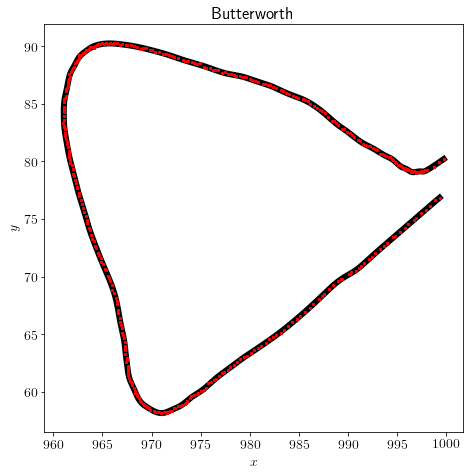

In [216]:
it=60
step = 4

xb = butter_lowpass(0.8,step,info.fps[0],tracks[it].x)
yb = butter_lowpass(0.8,step,info.fps[0],tracks[it].y)


#xc = cheby1_lowpass(step,info.fps[0],tracks[it].x)
#yc = cheby1_lowpass(step,info.fps[0],tracks[it].y)
#
fig= plt.figure(figsize=(7.5,7.5))

#ax=plt.subplot(121)


px_size = 72./fig.dpi
plt.title('Butterworth')
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.plot(xb,yb, linewidth=6,c='k')
plt.plot(tracks[it].x,tracks[it].y,'s', c='r',markersize=2*px_size)
#print(tr_lengths[it])

#ax=plt.subplot(122)
#px_size = 72./fig.dpi
#plt.title('Chebyshev type I')
#plt.xlabel(r'$x$')
#plt.ylabel(r'$y$')
#plt.plot(xc,yc, linewidth=6,c='k')
#plt.plot(tracks[it].x,tracks[it].y,'s', c='r',markersize=2*px_size)
#
print(tr_lengths[it],'frame length of possible maximum', Nframes)


#### Differences filtering

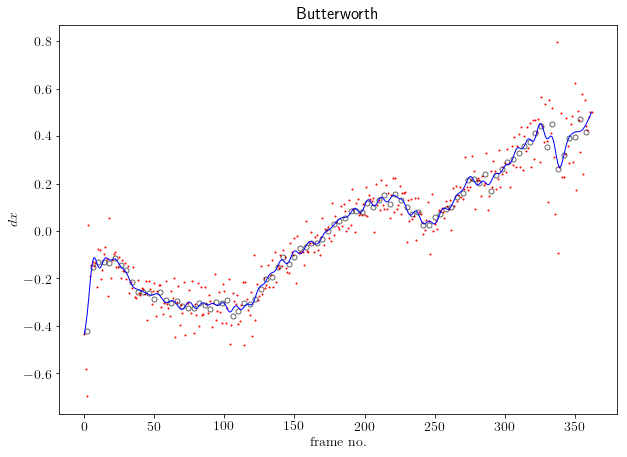

In [217]:
it = 60
step = 4

vx_gr = grain(tracks[it].x, step)
vy_gr = grain(tracks[it].y, step)

vxb = butter_lowpass(0.9,step, info.fps[0], tracks[it].vx)

vxc= cheby1_lowpass(step, info.fps[0], tracks[it].vx)

fig= plt.figure(figsize=(10,10/ct.golden))
px_size = 72./fig.dpi

#ax=plt.subplot(211)
plt.title('Butterworth')

plt.xlabel(r'$\mathrm{frame~no.}$')
plt.ylabel(r'$dx$')
plt.plot(tracks[it].vx,'o',c='r', markersize=px_size, linewidth=None)
plt.plot(vx_gr.T[0], vx_gr.T[1],'o',c='k',mfc='None',markersize=5,linewidth=None,alpha=0.6)
plt.plot(vxb,linewidth=1,c='b')


#ax=plt.subplot(212)
#plt.title('Chebyshev type I')
#
#plt.xlabel(r'$\mathrm{frame~no.}$')
#plt.ylabel(r'$dx$')
#plt.plot(tracks[it].vx,'o',c='r',markersize=px_size, linewidth=None)
#plt.plot(vx_gr.T[0], vx_gr.T[1],'o',c='k',mfc='None',markersize=5,linewidth=None,alpha=0.6)
#plt.plot(vxc,linewidth=1,c='b')

plt.subplots_adjust(hspace=0.275, top=0.95, bottom=0.075)

## _Plotting functions_ 

__frameit(ax):__ frames a figure by drawing the image limits and the ROI limits as well

__plt__\___track(t_id,xs,tagit,fr\_it):__ plots just one track (_t_\__id_) within _frameit_ (if True) frames, with size _xs_ and prints the track no. if _tagit_ is True

__plt__\___tracks(init_id, final_id,xs,tagit,fr\_it):__ plots _init_\__id_ to _final_\__id_ tracks within _frameit_ (if True) frames, with size _xs_ and prints the track no. if _tagit_ is True

In [138]:
def frameit(ax):
    ax.set_xlim(0,info['shape'][0][0])
    ax.set_ylim(0,info['shape'][0][1])
    rect = plt.Rectangle([250,50], 750, 600, alpha=1, lw=10,fill=False, edgecolor='b')
    ax.add_artist(rect)

def plt_track(t_id,xs,tagit,fr_it):
    if fr_it==True:
        fig, ax = plt.subplots(figsize=(xs,xs*info['shape'][0][1]/info['shape'][0][0]))
        px_size = 72./fig.dpi
        frameit(ax)
    else:
        fig, ax = plt.subplots()
        px_size = 72./fig.dpi
        
    plt.plot(tracks[t_id].x,tracks[t_id].y, '.', c='r', markersize=px_size,linewidth=None)
    if tagit==True:
        plt.text(np.mean(tracks[t_id].x), np.mean(tracks[t_id].y), str(t_id))
            
def plt_tracks(init_id,final_id,xs,tagit,fr_it):
    if fr_it==True:
        fig, ax = plt.subplots(figsize=(xs,xs*info['shape'][0][1]/info['shape'][0][0]))
        px_size = 72./fig.dpi
        frameit(ax)
    else:
        fig, ax = plt.subplots()
        px_size = 72./fig.dpi
    for i in range(init_id,final_id+1):
        plt.plot(tracks[i].x,tracks[i].y, '.', c='r', markersize=px_size,linewidth=None)
        if tagit==True:
            plt.text(np.mean(tracks[i].x), np.mean(tracks[i].y), str(i))

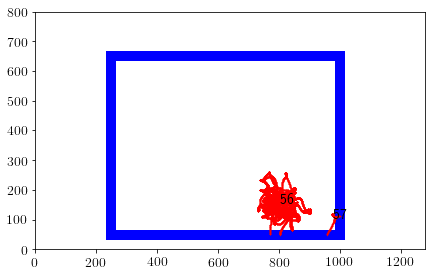

In [132]:
plt_tracks(56,57,7,True,True)

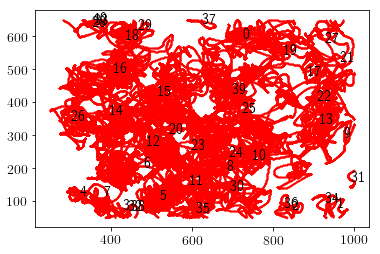

In [144]:
plt_tracks(0,40,7,True,False)

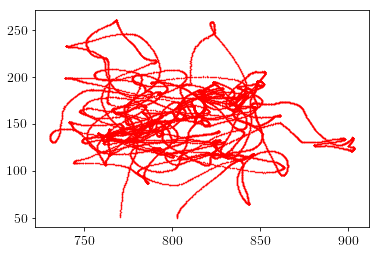

In [139]:
plt_track(56,7,False,False)

In [100]:
it = 150
xs=7
fig, ax = plt.subplots(figsize=(xs,xs*info['shape'][0][1]/info['shape'][0][0]))
frameit(ax)
plt.plot(tracks[it].x,tracks[it].y, '.', c='r', markersize=px_size,linewidth=None)
plt.text(np.mean(tracks[it].x), np.mean(tracks[it].y), str(it))

## Bring data to physical units

We take as coordinate origin the mid-point of the max and min X and Y positions ever tracked within the region of interest (ROI) during the experiment.

We have 2 options for lengh unit: 
* milimeters 
* Ball diameter

The time scale unit is seconds.

Only after this step position differences in the original data table are re-scaled as real velocities

In [459]:
# PHYSICAL SCALES AND ORIGIN
# Usage: re_pos_scale(0) for 1 mm as length unit; re_pos_scale(1) for ball diameter (sigma) 
# length unit

def scale(l_unit, t_unit, tabla):
    inv_l_unit = 1./l_unit
    tabla_scaled = tabla.copy()
    #tabla_scaled = pd.DataFrame(np.zeros(np.shape(tabla)), columns = c_xy)
    if np.any(tabla.columns=='vx') or np.any(tabla.columns=='vy'):
        tabla_scaled[['x','y', 'vx', 'vy']] = tabla[['x','y','vx','vy']] * inv_l_unit
        tabla_scaled[['vx', 'vy']] = tabla_scaled[['vx', 'vy']] * t_unit
    else:
        tabla_scaled[['x','y']] = tabla[['x','y']] * inv_l_unit
    return tabla_scaled


## Static structure functions 

## <font color=crimson>PAIR CORRELATION FUNCTION _g(r)_</font>

In [233]:
# TRUE RADIAL DISTRIBUTION FUNCTION, simple version, no corner corrections

def gr(tabla, nrbin, LX, LY):
    global dr, hist, edges
    # The number of g(r) measurements is the binomial cofficient
    # since the points order in pairs does not matter; i.e., g(ri-rj)=g(rj-ri)
    npart = len(tabla)
    nr_measures = int(spec.binom(npart,2 ))
    #print('measures per bin: ', nr_measures/nrbin) # print no. of measuremnts per bin
    # calculate the bin size, relative to particle radii
    drr = np.sqrt(LX**2 + LY**2)/nrbin
    # initialize array of radial distr function distances array and bin index
    dr = np.zeros(nr_measures)
    ii = 0
    # Loop over all statistically relevant particle pairs
    # calculating distances
    for i in range(npart-1):
        if (i%100==0 and i > 0):
            printp(str(i)+ ' particles performed')
        for j in range(i+1,npart):
            dr[ii] = (tabla.x[i]-tabla.x[j])**2 + (tabla.y[i]- tabla.y[j])**2
            if dr[ii]<78:
                print('careful\n')
            ii = ii +1
    dr = np.sqrt(dr)
    # count number of measured distances per bin; i.e., get the g(r)
    hist, edges = np.histogram(dr,bins=nrbin)
    # create array of bin centers
    r= [edges[i] - 0.5*drr for i in range(len(hist))]
    # normalize the radial distribution function
    g = [ (LX*LY/npart)*hist[i]/(2*np.pi*drr*r[i]) for i in range(len(hist))]
    #r = r[:-1]
    return r, g

In [237]:
r, g = gr(state(50,datos_250), 200, 750,600 )

In [240]:
hist

array([2, 1, 2, 2, 0, 3, 0, 0, 2, 1, 2, 1, 2, 3, 3, 2, 2, 2, 3, 0, 2, 2,
       2, 4, 1, 4, 2, 5, 4, 1, 0, 0, 4, 1, 2, 1, 5, 1, 3, 1, 2, 0, 0, 0,
       1, 1, 2, 0, 6, 4, 1, 6, 3, 3, 3, 3, 2, 2, 2, 5, 2, 3, 4, 2, 0, 3,
       0, 4, 2, 2, 4, 1, 1, 5, 1, 3, 1, 3, 1, 2, 1, 5, 1, 2, 0, 2, 0, 4,
       1, 3, 2, 5, 7, 0, 3, 1, 8, 5, 3, 1, 4, 0, 1, 1, 2, 1, 3, 1, 2, 2,
       2, 2, 1, 1, 2, 2, 3, 1, 0, 1, 3, 4, 1, 1, 0, 2, 0, 3, 2, 2, 3, 2,
       3, 1, 2, 1, 1, 2, 2, 1, 2, 2, 0, 1, 1, 2, 0, 1, 0, 0, 0, 1, 1, 2,
       1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 3, 3, 2, 1, 0, 2, 0, 0, 1, 0,
       0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 3])

In [225]:
Nt = int(np.max(datos_250.frame))
gdr = [ np.zeros(100) for i in range(Nt)]

for i in range(1,Nt):
    if (i%100==0 and i > 0):
        printp(str(i)+ ' states performed out of '+str(Nt))
    r, gdr[i] = gr(state(i,datos_250), 100, 750,600 )


24900 states performed out of 24981

In [236]:
np.sqrt(750**2 + 600**2)

960.4686356149273

In [226]:
g = np.array(gdr[1])
for i in range(2,Nt):
    g = g + np.array(gdr[i])
g = g/(1.0*Nt)

In [232]:
edges

array([ 87.78890208,  94.31356349, 100.83822489, 107.3628863 ,
       113.88754771, 120.41220912, 126.93687052, 133.46153193,
       139.98619334, 146.51085474, 153.03551615, 159.56017756,
       166.08483897, 172.60950037, 179.13416178, 185.65882319,
       192.1834846 , 198.708146  , 205.23280741, 211.75746882,
       218.28213023, 224.80679163, 231.33145304, 237.85611445,
       244.38077586, 250.90543726, 257.43009867, 263.95476008,
       270.47942148, 277.00408289, 283.5287443 , 290.05340571,
       296.57806711, 303.10272852, 309.62738993, 316.15205134,
       322.67671274, 329.20137415, 335.72603556, 342.25069697,
       348.77535837, 355.30001978, 361.82468119, 368.34934259,
       374.874004  , 381.39866541, 387.92332682, 394.44798822,
       400.97264963, 407.49731104, 414.02197245, 420.54663385,
       427.07129526, 433.59595667, 440.12061808, 446.64527948,
       453.16994089, 459.6946023 , 466.21926371, 472.74392511,
       479.26858652, 485.79324793, 492.31790933, 498.84

In [231]:
r

[92.59124525673954,
 99.11590666409144,
 105.64056807144334,
 112.16522947879523,
 118.68989088614713,
 125.21455229349903,
 131.73921370085094,
 138.26387510820283,
 144.7885365155547,
 151.31319792290662,
 157.8378593302585,
 164.3625207376104,
 170.8871821449623,
 177.41184355231422,
 183.93650495966608,
 190.461166367018,
 196.9858277743699,
 203.5104891817218,
 210.03515058907368,
 216.5598119964256,
 223.08447340377748,
 229.6091348111294,
 236.13379621848128,
 242.65845762583317,
 249.18311903318508,
 255.70778044053696,
 262.2324418478889,
 268.7571032552408,
 275.28176466259265,
 281.80642606994456,
 288.3310874772964,
 294.85574888464834,
 301.38041029200025,
 307.90507169935216,
 314.4297331067041,
 320.95439451405593,
 327.47905592140785,
 334.0037173287597,
 340.5283787361116,
 347.05304014346353,
 353.57770155081545,
 360.10236295816736,
 366.6270243655193,
 373.1516857728711,
 379.676347180223,
 386.2010085875749,
 392.7256699949268,
 399.25033140227873,
 405.77499280963

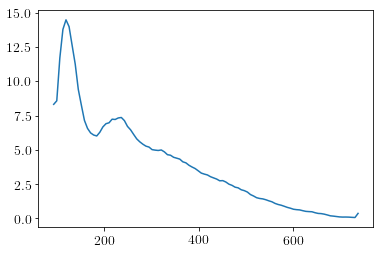

In [227]:
plt.plot(r,g)

In [165]:
np.histogram(dr,bins=30)

(array([10,  8, 15, 17, 14, 14,  6, 21, 19, 14, 16, 14, 11, 22, 21, 11, 12,
         9, 11, 16,  9,  8,  4,  4,  4,  9,  2,  1,  0,  3]),
 array([ 77.81335055,  99.77047101, 121.72759147, 143.68471193,
        165.64183239, 187.59895285, 209.55607331, 231.51319377,
        253.47031423, 275.42743469, 297.38455516, 319.34167562,
        341.29879608, 363.25591654, 385.213037  , 407.17015746,
        429.12727792, 451.08439838, 473.04151884, 494.9986393 ,
        516.95575976, 538.91288022, 560.87000068, 582.82712115,
        604.78424161, 626.74136207, 648.69848253, 670.65560299,
        692.61272345, 714.56984391, 736.52696437]))

In [164]:
len(edges)

21

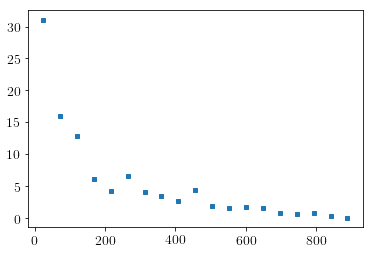

In [150]:
plt.plot(r[:-1],np.array(g),'s',markersize=4)

In [145]:
np.array(g)+1

array([32.05462304, 16.92544771, 13.89961265,  7.14267269,  5.24678606,
        7.51495588,  5.04261365,  4.5035985 ,  3.66985447,  5.40045266,
        2.93380437,  2.55792423,  2.71994835,  2.59254477,  1.74135705,
        1.53941033,  1.79627239,  1.27300768,  1.06456263])

## VELOCITY AUTOCORRELATIONS

In [17]:
#VELOCITY AUTOCORRELATION functions

# correlations for a track
def vel_autocorr_track(tabla):
    lt = len(tabla)
    vacx = np.empty(lt-1)
    vacy = np.empty(lt-1)
    tvc = np.empty(lt-1)
    for i in range(1,lt-1):
        tvc[i-1] = i
        vacx[i-1] = np.dot(tabla.vx[:-i], tabla.vx[i:])/(lt-i)
        vacy[i-1] = np.dot(tabla.vy[:-i], tabla.vy[i:])/(lt-i)
    return tvc, vacx, vacy

# correlations average for all kept tracks
def vel_autocorr(tabla):
    av_vacx = np.zeros(Nframes-1)
    av_vacy = np.zeros(Nframes-1)
    no_measurmnts = np.zeros(Nframes,dtype=int)
    for i in range(Ntracks):
        tvc, vacx, vacy = vel_autocorr_track(tracks[i])
        av_vacx[:tr_lengths[i]-1] = av_vacx[:tr_lengths[i]-1] + vacx
        av_vacy[:tr_lengths[i]-1] = av_vacy[:tr_lengths[i]-1] + vacy
        no_measurmnts[:tr_lengths[i]] = no_measurmnts[:tr_lengths[i]] + 1
        printp('track ' + str(i) + ' of ' + str(Ntracks))
    for i in range(Nframes-1):
        av_vacx[i] = av_vacx[i]/no_measurmnts[i]
        av_vacy[i] = av_vacy[i]/no_measurmnts[i]
    return av_vacx, av_vacy


In [16]:
tracks = all_tracks(datos_1000)

In [26]:
tvc, vacx, vacy = vel_autocorr_track(tracks[1])

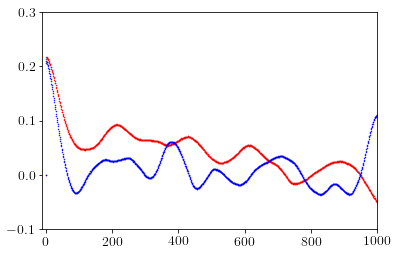

In [28]:
# track10 , datos_2000
fig= plt.figure(1)
px_size = 72./fig.dpi
plt.xlim(-10,1000)
plt.ylim(-0.1,0.3)
plt.scatter(tvc, vacx, marker='.',color='red', s=px_size)
plt.scatter(tvc, vacy, marker='.',color='blue', s=px_size)

In [87]:
#fig=plt.figure(1,figsize=(14,14*info['shape'][0][1]/info['shape'][0][0]))
fig, ax = plt.subplots(figsize=(14,14*info['shape'][0][1]/info['shape'][0][0]))
px_size = 72./fig.dpi

frameit(ax)
#ax.set_xlim(0,info['shape'][0][0])
#ax.set_ylim(0,info['shape'][0][1])

for i in range(Ntracks):
    plt.plot(tracks[i].x,tracks[i].y, '.', c='r', markersize=px_size,linewidth=None)
    plt.text(np.mean(tracks[i].x), np.mean(tracks[i].y), str(i))
    #print('var_vx(', str(i),'): ', np.var(tracks[i].vx), '\tvar_vy(', str(i),'): ', np.var(tracks[i].vy))
#plt.plot(info.ROI_center[0][0],info.ROI_center[0][1], 'o', markersize =15*px_size, c='k')
#ax.add_artist(plt.Rectangle((250,50),750,600, facecolor='b',alpha=0.2))

## Análisis N=60 (21-05-19)

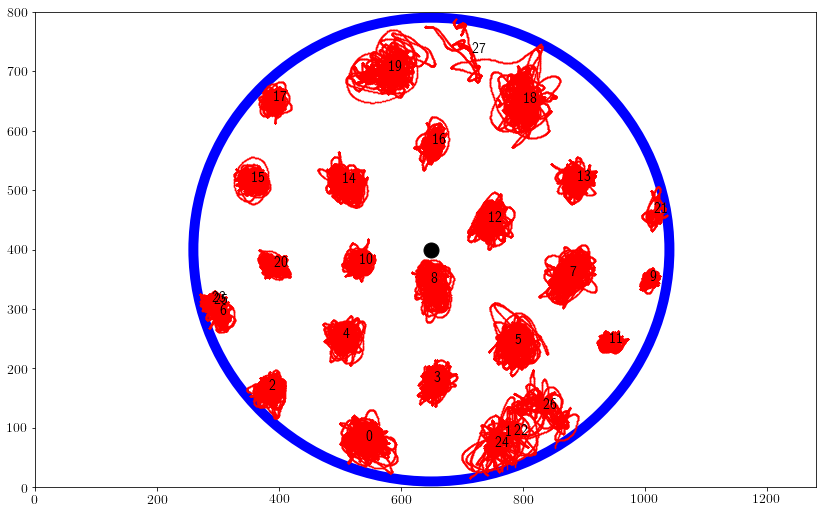

In [14]:
#fig=plt.figure(1,figsize=(14,14*info['shape'][0][1]/info['shape'][0][0]))
fig, ax = plt.subplots(figsize=(14,14*info['shape'][0][1]/info['shape'][0][0]))
px_size = 72./fig.dpi

ax.set_xlim(0,info['shape'][0][0])
ax.set_ylim(0,info['shape'][0][1])

circle2 = plt.Circle((info.ROI_center[0][0], info.ROI_center[0][1]), info.ROI_radius[0], alpha=1, lw=10,fill=False, edgecolor='b')

for i in range(Ntracks):
    plt.plot(tracks[i].x,tracks[i].y, '.', c='r', markersize=px_size,linewidth=None)
    plt.text(np.mean(tracks[i].x), np.mean(tracks[i].y), str(i))
    #print('var_vx(', str(i),'): ', np.var(tracks[i].vx), '\tvar_vy(', str(i),'): ', np.var(tracks[i].vy))

plt.plot(info.ROI_center[0][0],info.ROI_center[0][1], 'o', markersize =15*px_size, c='k')
ax.add_artist(circle2)


In [11]:
0.5*(np.mean(datos_2500.vx.values**2)+np.mean(datos_2500.vy.values**2))*(250./78)**2

0.9487918578505043

In [20]:
state(Nframes-1,datos_2500)

,frame,track,x,y,vx,vy
0,24981,0,559.268711,59.795582,0.0,0.0
1,24981,2,386.563325,163.214344,0.0,0.0
2,24981,3,639.544304,204.908354,0.0,0.0
3,24981,4,494.003145,254.795101,0.0,0.0
4,24981,5,773.842824,232.533800,0.0,0.0
5,24981,7,855.739316,334.142906,0.0,0.0
6,24981,8,670.424551,299.321126,0.0,0.0
7,24981,9,1003.756114,346.554606,0.0,0.0
8,24981,10,513.815190,376.381266,0.0,0.0
9,24981,11,929.670982,249.570171,0.0,0.0


<IPython.core.display.Javascript object>


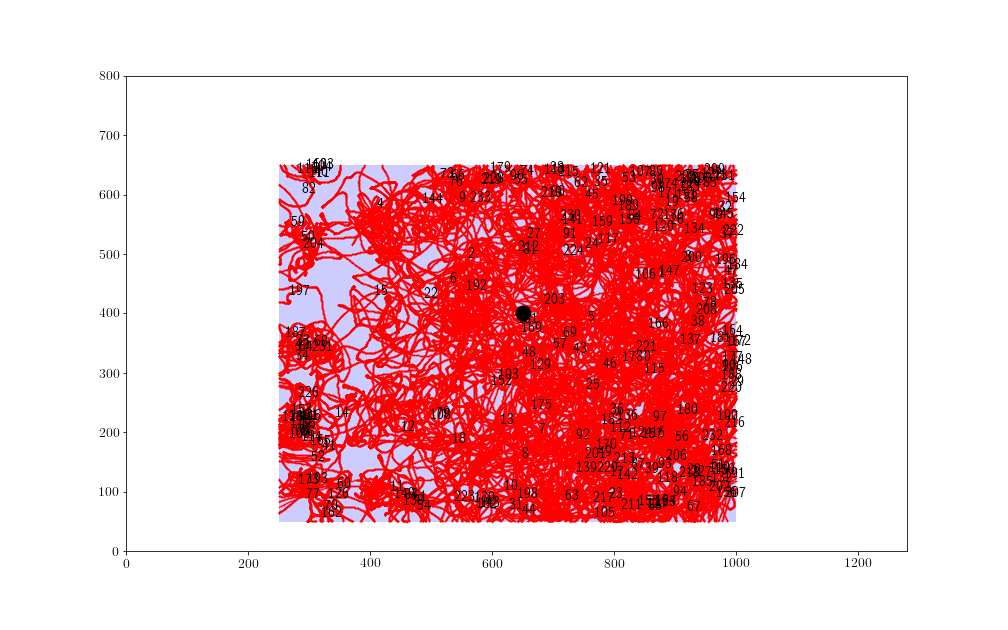

var_vx( 0 ):  0.1299937087277276 	var_vy( 0 ):  0.20482879124325815
var_vx( 1 ):  0.10280677270369336 	var_vy( 1 ):  0.13990205032783148
var_vx( 2 ):  0.187041910810308 	var_vy( 2 ):  0.1547921422841545
var_vx( 3 ):  0.13127564253728952 	var_vy( 3 ):  0.1274052211731038
var_vx( 4 ):  0.09288908999161397 	var_vy( 4 ):  0.023453290617704677
var_vx( 5 ):  0.14029749425649926 	var_vy( 5 ):  0.09861064330975343
var_vx( 6 ):  0.14597040127287994 	var_vy( 6 ):  0.14892820942047855
var_vx( 7 ):  0.12309063261353699 	var_vy( 7 ):  0.17331335780708504
var_vx( 8 ):  0.1081717932268771 	var_vy( 8 ):  0.09982366100024924
var_vx( 9 ):  0.1174075022377928 	var_vy( 9 ):  0.08345173448315085
var_vx( 10 ):  0.1420906022819281 	var_vy( 10 ):  0.06145742496765957
var_vx( 11 ):  0.09023722195523616 	var_vy( 11 ):  0.05860005446203789
var_vx( 12 ):  0.08960109327989206 	var_vy( 12 ):  0.0831345264665806
var_vx( 13 ):  0.11659042021223975 	var_vy( 13 ):  0.12415020141129723
var_vx( 14 ):  0.03940176697891619

In [100]:
#fig=plt.figure(1,figsize=(14,14*info['shape'][0][1]/info['shape'][0][0]))
fig, ax = plt.subplots(figsize=(14,14*info['shape'][0][1]/info['shape'][0][0]))
px_size = 72./fig.dpi

ax.set_xlim(0,info['shape'][0][0])
ax.set_ylim(0,info['shape'][0][1])

for i in range(Ntracks):
    plt.plot(tracks[i].x,tracks[i].y, '.', c='r', markersize=px_size,linewidth=None)
    plt.text(np.mean(tracks[i].x), np.mean(tracks[i].y), str(i))
    print('var_vx(', str(i),'): ', np.var(tracks[i].vx), '\tvar_vy(', str(i),'): ', np.var(tracks[i].vy))
#plt.plot(tracks[10].x,tracks[10].y, c= 'b', marker='.', markersize=px_size,linewidth=None)

plt.plot(info.ROI_center[0][0],info.ROI_center[0][1], 'o', markersize =15*px_size, c='k')
ax.add_artist(plt.Rectangle((250,50),750,600, facecolor='b',alpha=0.2))

var_vx( 0 ):  0.19012002539312248 	var_vy( 0 ):  0.168297504013481
var_vx( 1 ):  0.1949840465003442 	var_vy( 1 ):  0.21137478225836814
var_vx( 2 ):  0.14717269156140575 	var_vy( 2 ):  0.12674696489520126
var_vx( 3 ):  0.18750235477050795 	var_vy( 3 ):  0.21698688116945675
var_vx( 4 ):  0.262883833613916 	var_vy( 4 ):  0.1755984420581195
var_vx( 5 ):  0.08884386607352446 	var_vy( 5 ):  0.10024979984461509
var_vx( 6 ):  0.1333906259925828 	var_vy( 6 ):  0.14869978520753838
var_vx( 7 ):  0.13702036266279685 	var_vy( 7 ):  0.22142391663541197
var_vx( 8 ):  0.1624666008768169 	var_vy( 8 ):  0.16342638946846808
var_vx( 9 ):  0.24144408707760048 	var_vy( 9 ):  0.09128074787127907
var_vx( 10 ):  0.08835997793036629 	var_vy( 10 ):  0.14345308455774883
var_vx( 11 ):  0.16547531121693518 	var_vy( 11 ):  0.1756142182234421
var_vx( 12 ):  0.15190537785006938 	var_vy( 12 ):  0.1798838888283661
var_vx( 13 ):  0.09076530379811289 	var_vy( 13 ):  0.1849543225999364
var_vx( 14 ):  0.03357403631334721 	v

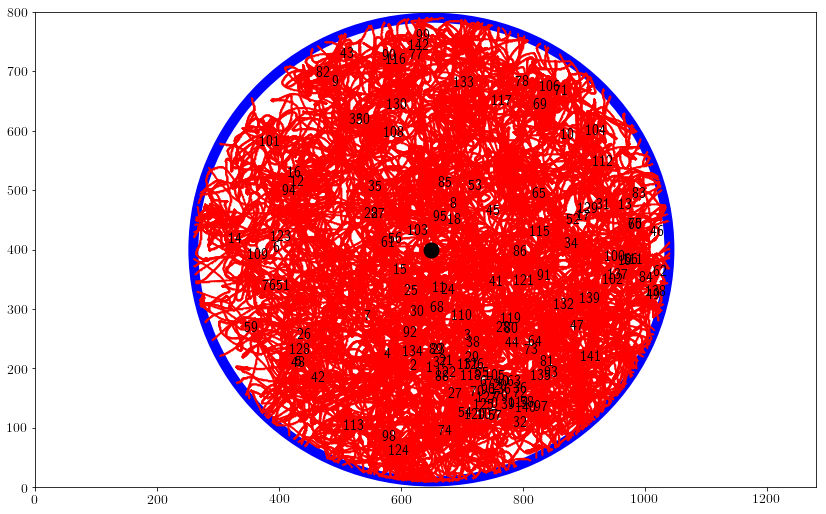

In [21]:
#fig=plt.figure(1,figsize=(14,14*info['shape'][0][1]/info['shape'][0][0]))
fig, ax = plt.subplots(figsize=(14,14*info['shape'][0][1]/info['shape'][0][0]))
px_size = 72./fig.dpi

circle2 = plt.Circle((info.ROI_center[0][0], info.ROI_center[0][1]), info.ROI_radius[0], alpha=1, lw=10,fill=False, edgecolor='b')

ax.set_xlim(0,info['shape'][0][0])
ax.set_ylim(0,info['shape'][0][1])

for i in range(Ntracks):
    plt.plot(tracks[i].x,tracks[i].y, c='r', marker='.', markersize=px_size,linewidth=None)
    plt.text(np.mean(tracks[i].x), np.mean(tracks[i].y), str(i))
    print('var_vx(', str(i),'): ', np.var(tracks[i].vx), '\tvar_vy(', str(i),'): ', np.var(tracks[i].vy))
#plt.plot(tracks[10].x,tracks[10].y, c= 'b', marker='.', markersize=px_size,linewidth=None)

plt.plot(info.ROI_center[0][0],info.ROI_center[0][1], 'o', markersize =15*px_size, c='k')
ax.add_artist(circle2)

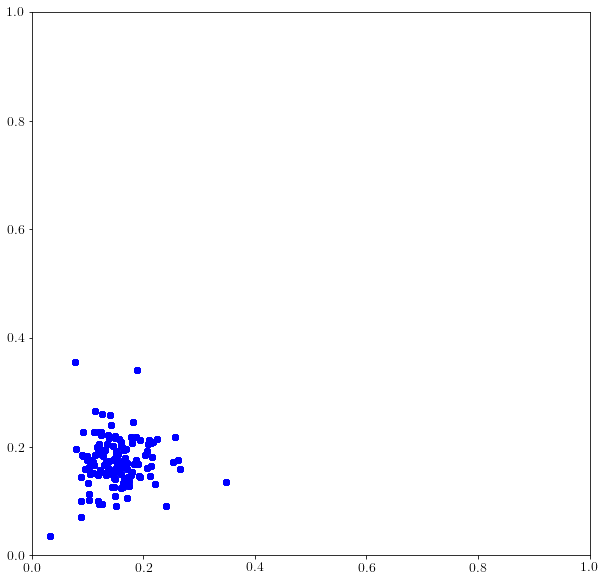

In [27]:
rx = [np.var(tracks[i].vx) for i in range(Ntracks)]
ry = [np.var(tracks[i].vy) for i in range(Ntracks)]
fig= plt.figure(figsize=(10,10))
plt.xlim(0,1)
plt.ylim(0,1)
px_size = 72./fig.dpi
for i in range(Ntracks):
    plt.plot(rx, ry, '.', c='b',markersize=10*px_size)
    #plt.text(rx[i], ry[i], str(i))

In [12]:
info.ROI_center

0    [650, 400]
Name: ROI_center, dtype: object

var_vx( 0 ):  0.12957782577064392 	var_vy( 0 ):  0.165895780001438
var_vx( 1 ):  0.15637413716362952 	var_vy( 1 ):  0.21482270133505027
var_vx( 2 ):  0.1480752887438056 	var_vy( 2 ):  0.14235806169144313
var_vx( 3 ):  0.13241239798771795 	var_vy( 3 ):  0.16933588605449781
var_vx( 4 ):  0.14962848031435658 	var_vy( 4 ):  0.17986928800989274
var_vx( 5 ):  0.12462385025307 	var_vy( 5 ):  0.22212049436821474
var_vx( 6 ):  0.1188595553735336 	var_vy( 6 ):  0.14721043864613378
var_vx( 7 ):  0.10988622458956104 	var_vy( 7 ):  0.15173341361607157
var_vx( 8 ):  0.1500351447059355 	var_vy( 8 ):  0.15843435704983044
var_vx( 9 ):  0.15991700451303992 	var_vy( 9 ):  0.20103759149264144
var_vx( 10 ):  0.11644911480477615 	var_vy( 10 ):  0.1997427123635264
var_vx( 11 ):  0.1484925335625593 	var_vy( 11 ):  0.2200511688294141
var_vx( 12 ):  0.16583690420910446 	var_vy( 12 ):  0.14118002928101436


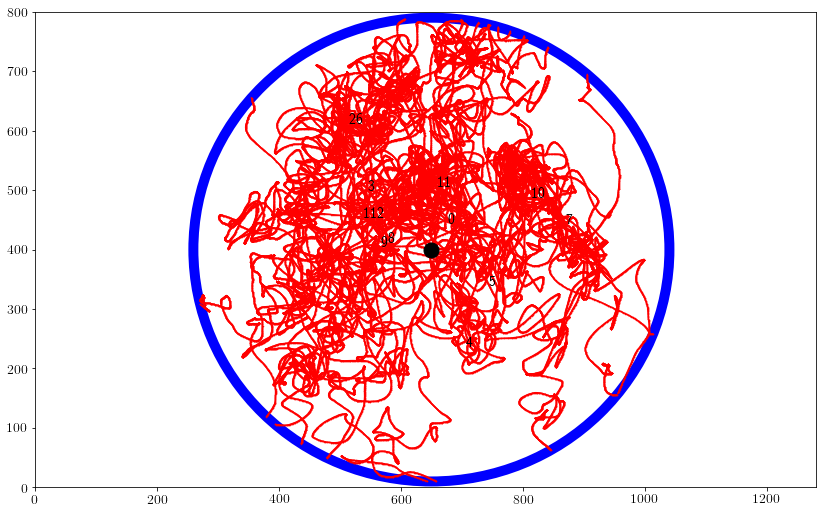

In [17]:
#fig=plt.figure(1,figsize=(14,14*info['shape'][0][1]/info['shape'][0][0]))
fig, ax = plt.subplots(figsize=(14,14*info['shape'][0][1]/info['shape'][0][0]))
px_size = 72./fig.dpi

circle2 = plt.Circle((info.ROI_center[0][0], info.ROI_center[0][1]), info.ROI_radius[0], alpha=1, lw=10,fill=False, edgecolor='b')

ax.set_xlim(0,info['shape'][0][0])
ax.set_ylim(0,info['shape'][0][1])

for i in range(Ntracks):
    plt.plot(tracks[i].x,tracks[i].y, c='r', marker='.', markersize=px_size,linewidth=None)
    plt.text(np.mean(tracks[i].x), np.mean(tracks[i].y), str(i))
    print('var_vx(', str(i),'): ', np.var(tracks[i].vx), '\tvar_vy(', str(i),'): ', np.var(tracks[i].vy))
#plt.plot(tracks[10].x,tracks[10].y, c= 'b', marker='.', markersize=px_size,linewidth=None)

plt.plot(info.ROI_center[0][0],info.ROI_center[0][1], 'o', markersize =15*px_size, c='k')
ax.add_artist(circle2)

## Análisis _N_=210

var_vx( 0 ):  0.14291149522303828 	var_vy( 0 ):  0.15362894722859813
var_vx( 1 ):  0.14233654332124085 	var_vy( 1 ):  0.13956661058485642
var_vx( 2 ):  0.14311760479772917 	var_vy( 2 ):  0.14817977943911068
var_vx( 3 ):  0.1403226393469653 	var_vy( 3 ):  0.13581757939201117
var_vx( 4 ):  0.13101636361682167 	var_vy( 4 ):  0.14747953802279506
var_vx( 5 ):  0.16698030814109605 	var_vy( 5 ):  0.15952648071795367
var_vx( 6 ):  0.14569608574461523 	var_vy( 6 ):  0.1521225810126581
var_vx( 7 ):  0.1586899055911083 	var_vy( 7 ):  0.14171710714514796
var_vx( 8 ):  0.1418093424234903 	var_vy( 8 ):  0.15724326578333522
var_vx( 9 ):  0.13831187570386336 	var_vy( 9 ):  0.13976818366955138
var_vx( 10 ):  0.14426259535553637 	var_vy( 10 ):  0.14160894847585043
var_vx( 11 ):  0.13530592131391486 	var_vy( 11 ):  0.13570593517715546
var_vx( 12 ):  0.13621112828294765 	var_vy( 12 ):  0.15111640947136046
var_vx( 13 ):  0.1438774790223 	var_vy( 13 ):  0.14551479614479262
var_vx( 14 ):  0.14441290174617435

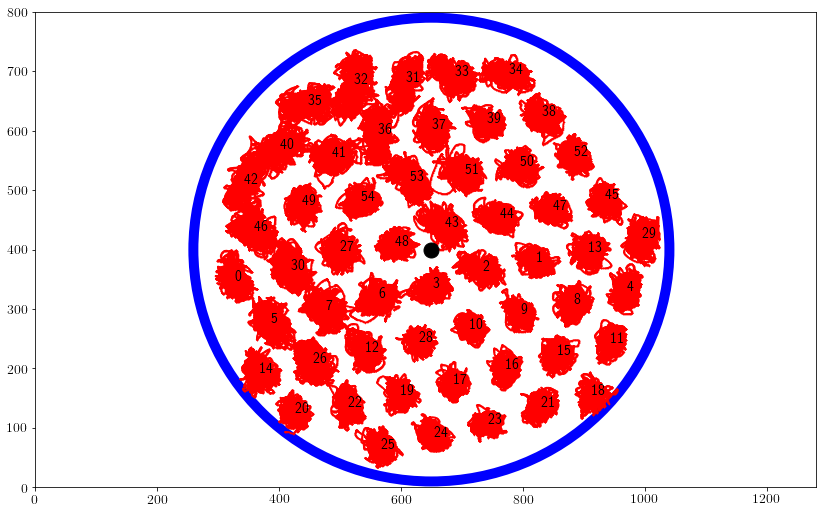

In [149]:
#fig=plt.figure(1,figsize=(14,14*info['shape'][0][1]/info['shape'][0][0]))
fig, ax = plt.subplots(figsize=(14,14*info['shape'][0][1]/info['shape'][0][0]))
px_size = 72./fig.dpi

circle2 = plt.Circle((info.ROI_center[0][0], info.ROI_center[0][1]), info.ROI_radius[0], alpha=1, lw=10,fill=False, edgecolor='b')

ax.set_xlim(0,info['shape'][0][0])
ax.set_ylim(0,info['shape'][0][1])

for i in range(Ntracks):
    plt.plot(tracks[i].x,tracks[i].y, c='r', marker='.', markersize=px_size,linewidth=None)
    plt.text(np.mean(tracks[i].x), np.mean(tracks[i].y), str(i))
    print('var_vx(', str(i),'): ', np.var(tracks[i].vx), '\tvar_vy(', str(i),'): ', np.var(tracks[i].vy))
#plt.plot(tracks[10].x,tracks[10].y, c= 'b', marker='.', markersize=px_size,linewidth=None)

plt.plot(info.ROI_center[0][0],info.ROI_center[0][1], 'o', markersize =15*px_size, c='k')
ax.add_artist(circle2)

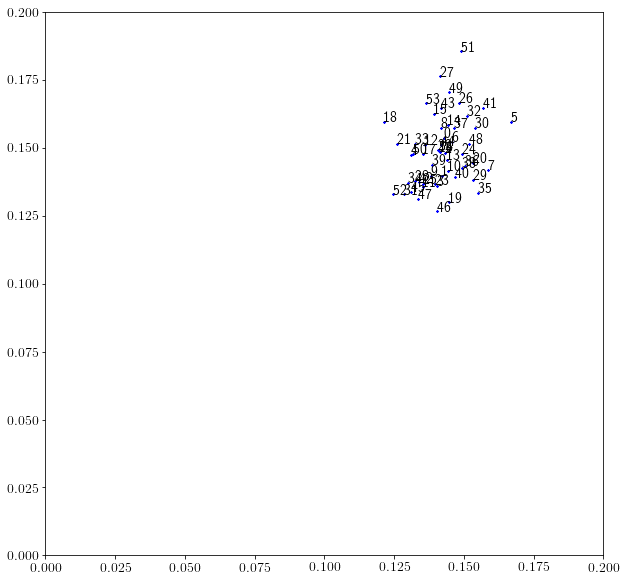

In [150]:
rx = [np.var(tracks[i].vx) for i in range(Ntracks)]
ry = [np.var(tracks[i].vy) for i in range(Ntracks)]
fig= plt.figure(figsize=(10,10))
plt.xlim(0,0.2)
plt.ylim(0,0.2)
px_size = 72./fig.dpi
for i in range(Ntracks):
    plt.plot(rx, ry, '.', c='b',markersize=px_size)
    plt.text(rx[i], ry[i], str(i))

## Análisis _N_=120

var_vx( 0 ):  0.14143422207955514 	var_vy( 0 ):  0.1473329860613765
var_vx( 1 ):  0.12567209805231677 	var_vy( 1 ):  0.17116556135194785
var_vx( 2 ):  0.14511220457189333 	var_vy( 2 ):  0.142231795397922
var_vx( 3 ):  0.11187124060400583 	var_vy( 3 ):  0.18595077272728805
var_vx( 4 ):  0.1340656085565059 	var_vy( 4 ):  0.11530006161327064
var_vx( 5 ):  0.13032716015614 	var_vy( 5 ):  0.17745017047451533
var_vx( 6 ):  0.11110953996379666 	var_vy( 6 ):  0.15525304742140172
var_vx( 7 ):  0.1106119221957355 	var_vy( 7 ):  0.14547677260102215
var_vx( 8 ):  0.12550289867072287 	var_vy( 8 ):  0.14476306149228457
var_vx( 9 ):  0.10334468619156364 	var_vy( 9 ):  0.13000247149490157
var_vx( 10 ):  0.13664359998274914 	var_vy( 10 ):  0.17260594042216917
var_vx( 11 ):  0.15129922048244995 	var_vy( 11 ):  0.1633929987725724
var_vx( 12 ):  0.12432015264162846 	var_vy( 12 ):  0.12807625415031249
var_vx( 13 ):  0.16590314253510097 	var_vy( 13 ):  0.16547753731755066
var_vx( 14 ):  0.18007849646399499 

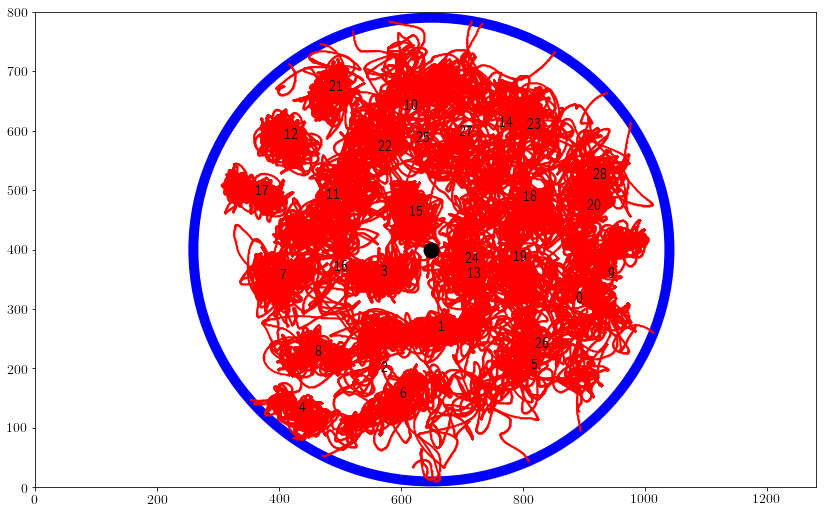

In [10]:
#fig=plt.figure(1,figsize=(14,14*info['shape'][0][1]/info['shape'][0][0]))
fig, ax = plt.subplots(figsize=(14,14*info['shape'][0][1]/info['shape'][0][0]))
px_size = 72./fig.dpi

circle2 = plt.Circle((info.ROI_center[0][0], info.ROI_center[0][1]), info.ROI_radius[0], alpha=1, lw=10,fill=False, edgecolor='b')

ax.set_xlim(0,info['shape'][0][0])
ax.set_ylim(0,info['shape'][0][1])

for i in range(Ntracks):
    plt.plot(tracks[i].x,tracks[i].y, c='r', marker='.', markersize=px_size,linewidth=None)
    plt.text(np.mean(tracks[i].x), np.mean(tracks[i].y), str(i))
    print('var_vx(', str(i),'): ', np.var(tracks[i].vx), '\tvar_vy(', str(i),'): ', np.var(tracks[i].vy))
#plt.plot(tracks[10].x,tracks[10].y, c= 'b', marker='.', markersize=px_size,linewidth=None)

plt.plot(info.ROI_center[0][0],info.ROI_center[0][1], 'o', markersize =15*px_size, c='k')
ax.add_artist(circle2)

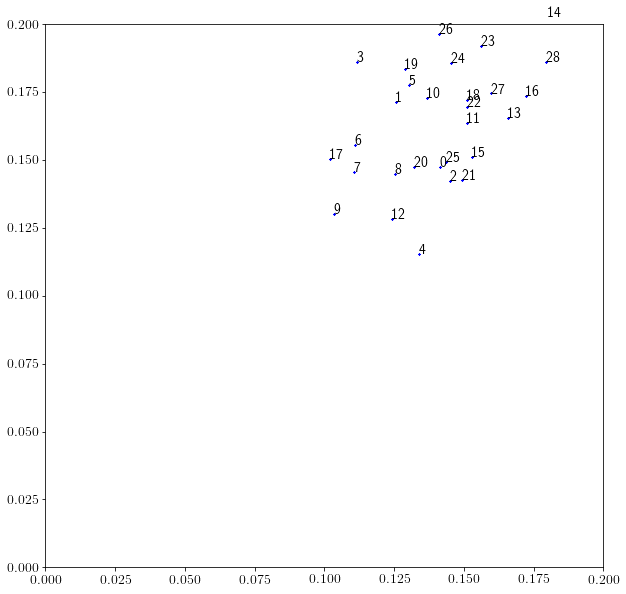

In [11]:
rx = [np.var(tracks[i].vx) for i in range(Ntracks)]
ry = [np.var(tracks[i].vy) for i in range(Ntracks)]
fig= plt.figure(figsize=(10,10))
plt.xlim(0,0.2)
plt.ylim(0,0.2)
px_size = 72./fig.dpi
for i in range(Ntracks):
    plt.plot(rx, ry, '.', c='b',markersize=px_size)
    plt.text(rx[i], ry[i], str(i))

## Análisis _N_=60

var_vx( 0 ):  0.09132023664314091 	var_vy( 0 ):  0.09627532623527328
var_vx( 1 ):  0.10826858205598797 	var_vy( 1 ):  0.11953930726715516
var_vx( 2 ):  0.09470789220756445 	var_vy( 2 ):  0.11491226088118248
var_vx( 3 ):  0.08633156972574588 	var_vy( 3 ):  0.1517303636332825
var_vx( 4 ):  0.08342072722670942 	var_vy( 4 ):  0.13965054717590258
var_vx( 5 ):  0.0978366076377086 	var_vy( 5 ):  0.12340243577872609
var_vx( 6 ):  0.07962423792453606 	var_vy( 6 ):  0.10157845793615855
var_vx( 7 ):  0.0742203970747942 	var_vy( 7 ):  0.034345582881907075
var_vx( 8 ):  0.10262011417298762 	var_vy( 8 ):  0.07818995779107281
var_vx( 9 ):  0.09751732123945596 	var_vy( 9 ):  0.054732725698383417
var_vx( 10 ):  0.05415645358790549 	var_vy( 10 ):  0.09585732355397657
var_vx( 11 ):  0.08287550591913267 	var_vy( 11 ):  0.09781998385223502
var_vx( 12 ):  0.06369822843511332 	var_vy( 12 ):  0.14174320928983627
var_vx( 13 ):  0.10304071627363953 	var_vy( 13 ):  0.10805825325278119
var_vx( 14 ):  0.0354089846

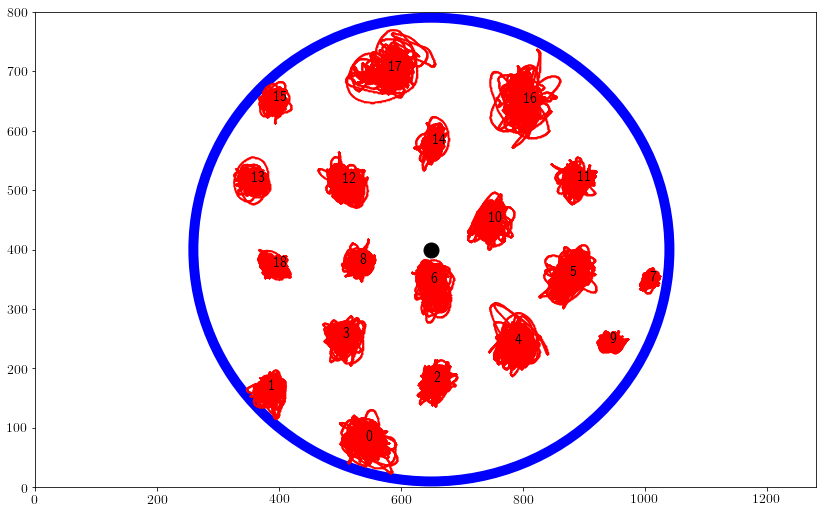

In [109]:
#fig=plt.figure(1,figsize=(14,14*info['shape'][0][1]/info['shape'][0][0]))
fig, ax = plt.subplots(figsize=(14,14*info['shape'][0][1]/info['shape'][0][0]))
px_size = 72./fig.dpi

circle2 = plt.Circle((info.ROI_center[0][0], info.ROI_center[0][1]), info.ROI_radius[0], alpha=1, lw=10,fill=False, edgecolor='b')

ax.set_xlim(0,info['shape'][0][0])
ax.set_ylim(0,info['shape'][0][1])

for i in range(Ntracks):
    plt.plot(tracks[i].x,tracks[i].y, c='r', marker='.', markersize=px_size,linewidth=None)
    plt.text(np.mean(tracks[i].x), np.mean(tracks[i].y), str(i))
    print('var_vx(', str(i),'): ', np.var(tracks[i].vx), '\tvar_vy(', str(i),'): ', np.var(tracks[i].vy))
#plt.plot(tracks[10].x,tracks[10].y, c= 'b', marker='.', markersize=px_size,linewidth=None)

plt.plot(info.ROI_center[0][0],info.ROI_center[0][1], 'o', markersize =15*px_size, c='k')
ax.add_artist(circle2)

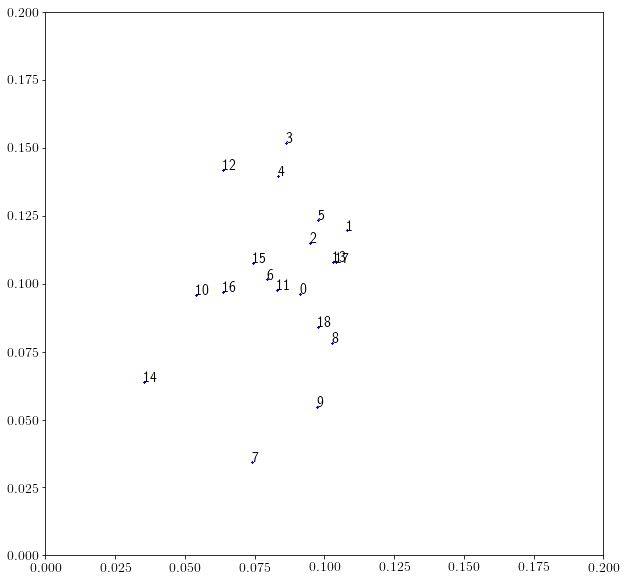

In [141]:
rx = [np.var(tracks[i].vx) for i in range(Ntracks)]
ry = [np.var(tracks[i].vy) for i in range(Ntracks)]
fig= plt.figure(figsize=(10,10))
plt.xlim(0,0.2)
plt.ylim(0,0.2)
px_size = 72./fig.dpi
for i in range(Ntracks):
    plt.plot(rx, ry, '.', c='b',markersize=px_size)
    plt.text(rx[i], ry[i], str(i))

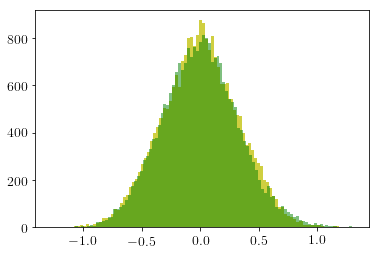

In [145]:
px_size = 72./fig.dpi
plt.hist(tracks[13].vy, 100, color='y', alpha=0.75);
plt.hist(tracks[17].vy, 100, color='g', alpha=0.5);

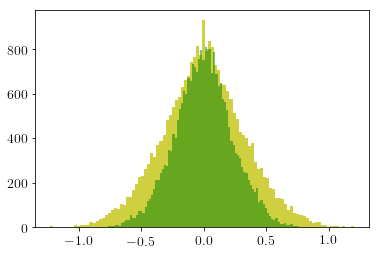

In [63]:
px_size = 72./fig.dpi
plt.hist(tracks[1].vx, 100, color='y', alpha=0.75);
plt.hist(tracks[10].vx, 100, color='g', alpha=0.5);

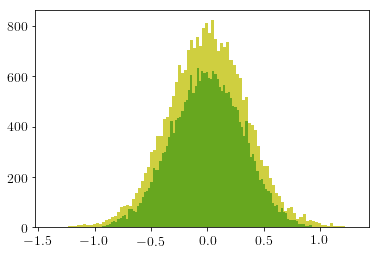

In [64]:
px_size = 72./fig.dpi
plt.hist(tracks[1].vy, 100, color='y', alpha=0.75);
plt.hist(tracks[10].vy, 100, color='g', alpha=0.5);

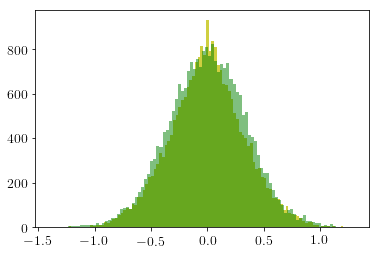

In [65]:
px_size = 72./fig.dpi
plt.hist(tracks[1].vx, 100, color='y', alpha=0.75);
plt.hist(tracks[1].vy, 100, color='g', alpha=0.5);

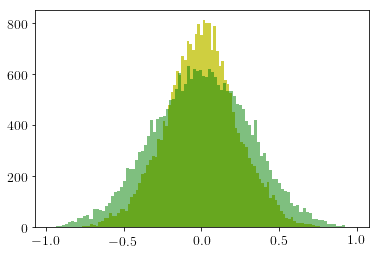

In [66]:
px_size = 72./fig.dpi
plt.hist(tracks[10].vx, 100, color='y', alpha=0.75);
plt.hist(tracks[10].vy, 100, color='g', alpha=0.5);

In [88]:
Ntracks

19

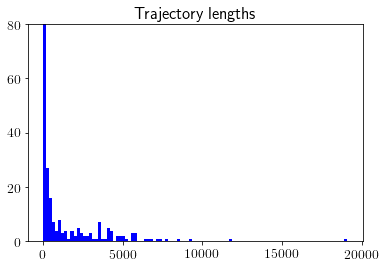

In [25]:
# Histogram of trajectory length
plt.figure(2)
plt.title('Trajectory lengths')
# set upper height limit for histogram
track_lengths = [len(tracks[i]) for i in range(Ntracks)]
plt.ylim(0, 80)
# number of bins
nbins = 100
#plot
plt.hist( track_lengths, nbins, color='b');

In [26]:
Nframes

24982

In [18]:
vels_diff(datos_10000);
#tabla_grad = vels_gradient(tabla)

diffs: 19 of 19 tracks



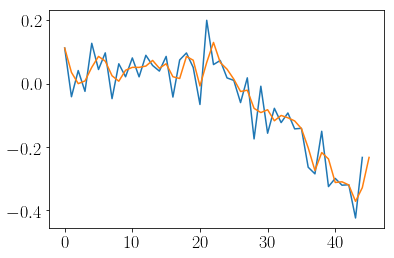

In [168]:
plt.figure(1)
plt.plot(np.diff(track(200, tabla, True).x))
plt.plot(np.gradient(track(200, tabla, True).x))

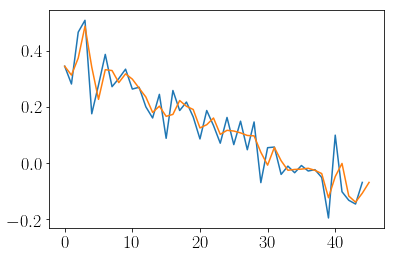

In [169]:
plt.figure(1)
plt.plot(np.diff(track(200, tabla, True).y))
plt.plot(np.gradient(track(200, tabla, True).y))

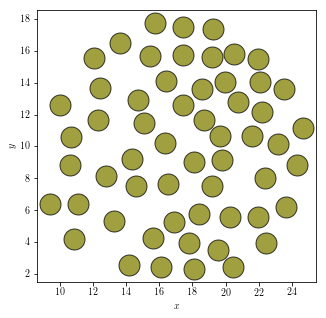

In [55]:
# DRAW INSTANTANEOUS STATE

it = 2

fig=plt.figure(0, figsize=(5,5))

plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
px_size = 72./fig.dpi
plt.scatter(state[it].x, state[it].y, color='olive', s=(21.*px_size)**2
            , edgecolors='k', alpha=0.75)

# USE CIRCLE COLLECTION INSTEAD
#    col = PolyCollection([inner[i][1] for i in range(n_inner)],
#                         linewidths=0.2, facecolor= colors_built)
#    col.set_edgecolors('k')
#    graf = ax.add_collection(col)

In [90]:
# OBTAIN ALL STATES

get_all_states(Nframes, tabla)

no. of states obtained: 24980of24982

In [88]:
Nframes

24981

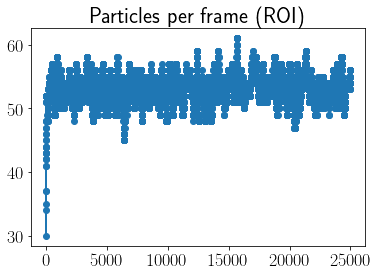

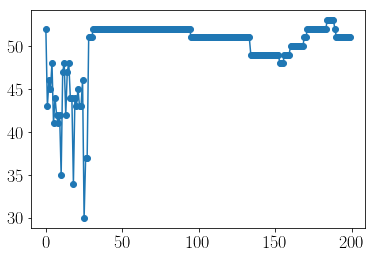

In [149]:
# plot no. of particles in each frame
plt.figure(1)
plt.title('Particles per frame (ROI)')
n_particles_frame=np.array([len(state[it]) for it in range(1,Nframes)])
plt.plot(n_particles_frame, marker='o')
plt.figure(2)
plt.plot(n_particles_frame[:200], marker='o')

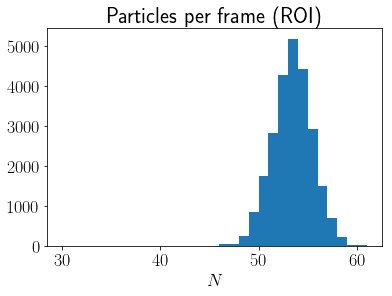

In [150]:
# Number of particles in each frame ROI. Histogram
plt.figure(1)
plt.title('Particles per frame (ROI)')
plt.xlabel(r'$N$')

n, bins, patches = plt.hist(n_particles_frame, bins=31)

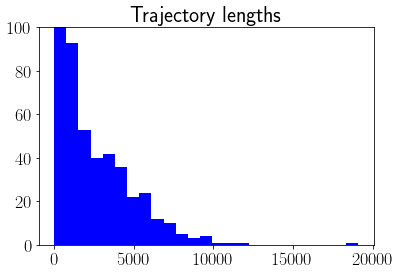

In [153]:
# Histogram of trajectory length
plt.figure(2)
plt.title('Trajectory lengths')
# set upper height limit for histogram
plt.ylim((0,100))
# number of bins
nbins = 25
#plot
plt.hist([len(track(i,tabla,True)) for i in range(Ntracks)], nbins, color='b');

In [173]:
# Total number of analyzed states (after discard of short trajectories)
np.sum([len(t[i]) for i in range(Ntrajec)])

1113887

In [ ]:
# Build array of times where particles trackings are 'lost
t_last = np.zeros(Ntrajec)
for i in range(Ntrajec):
    t_last[i] = t[i][-1]

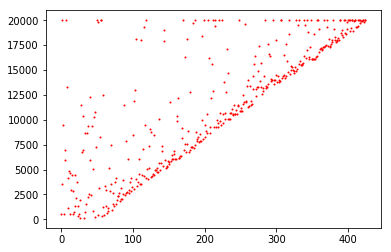

In [175]:
plt.figure(3)
plt.plot(t_last,marker='o',linewidth=0, markersize=1, color='r')

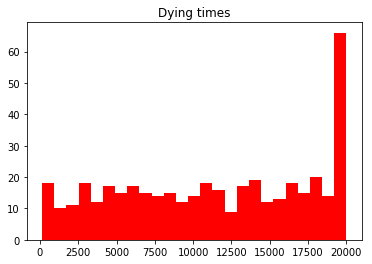

In [176]:
plt.figure(4)
plt.title('Dying times')
#number of bins
nbins = 25
#plot
plt.hist(t_last, nbins, color = 'r');

In [29]:
####### INDIVIDUAL TRAJECTORIES ##########
itraj = 45
xt = rtabla[(rtabla.trajec==45)].x
yt = rtabla[(rtabla.trajec==45)].y

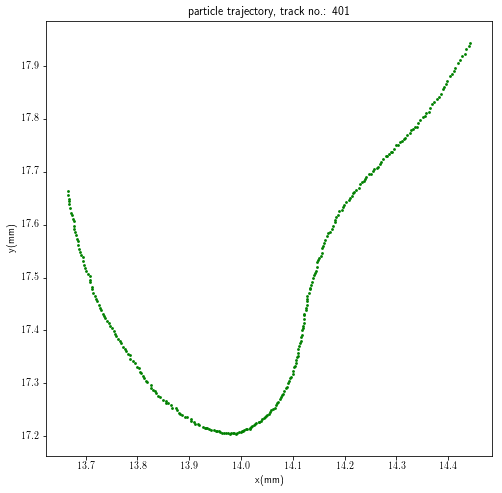

In [25]:
points= plt.figure(5,figsize=(8,8))

#size = 10
jump = 1

i_trajec = 401

plt.title('particle trajectory, track no.: '+str(i_trajec))
#plt.xlim((-size*0.5,size*0.5))
#plt.ylim((-size*0.5,size*0.5))

xt = rtabla[(rtabla.trajec==i_trajec)].x
yt = rtabla[(rtabla.trajec==i_trajec)].y

plt.xlabel('x(mm)')
plt.ylabel('y(mm)')
plt.scatter(xt[::jump], yt[::jump], 
            s=8, marker='o', c='g',edgecolors=None,linewidths=0)
plt.savefig('track401.pdf')

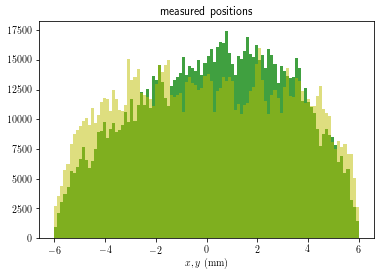

In [59]:
fig=plt.figure(6)
px_size = 72./fig.dpi
plt.title('measured positions')
plt.xlabel(r'$x, y~\mathrm{(mm)}$')
plt.hist((tabla.x -x0)/px_size, 100, color='g', alpha=0.75);
#plt.figure(3)
plt.hist((tabla.y -y0)/px_size, 100, color='y', alpha=0.5);
plt.savefig('xy_distr.pdf')

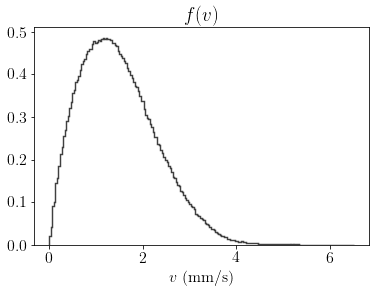

In [96]:
plt.figure(7)
plt.title(r'$f(v)$')
plt.xlabel(r'$v~\mathrm{(mm/s)}$')
plt.hist(np.sqrt((rtabla.vx**2+rtabla.vy**2)*0.5), 200,color='k',alpha=0.75
         ,normed=True, histtype='step',linewidth=1.45);
plt.savefig('fv.pdf',bbox_inches='tight')

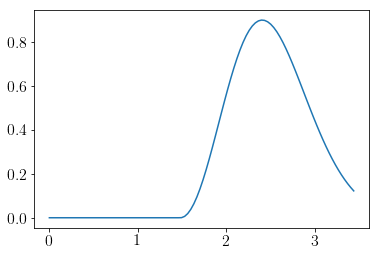

In [125]:
mu  = np.mean(np.sqrt((rtabla.vx**2+rtabla.vy**2)*0.5))
variance = np.var(np.sqrt((rtabla.vx**2+rtabla.vy**2)*0.5))
x = np.linspace(0, mu + 3*variance, 100)
plt.plot(x, st.maxwell.pdf(x,mu,variance))

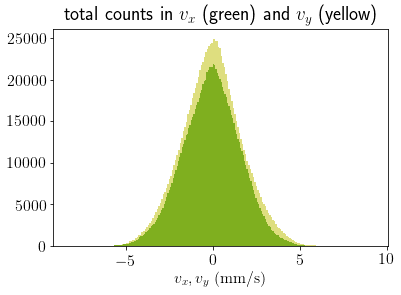

In [101]:
plt.figure(8)
plt.title(r'total counts in $v_x$ (green) and $v_y$ (yellow)')
plt.xlabel(r'$v_x, v_y~\mathrm{(mm/s)}$')

plt.hist(rtabla['vx'], 200,color='g',alpha=0.75,normed=False);
#plt.figure(5)
plt.hist(rtabla['vy'], 200,color='y',alpha=0.5,normed=False);
plt.savefig('f_vxvy_not_normed.pdf',bbox_inches='tight')

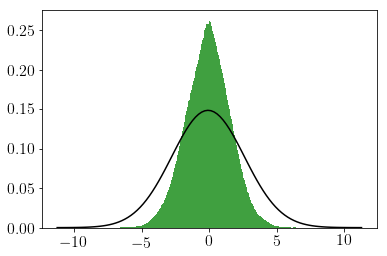

In [147]:
# v_x VARIANCE (mm/s^2)
x = np.linspace( -(mu + 15*variance), mu + 15*variance, 100)
meanx = np.mean(rtabla.vx)
variancex = np.var(rtabla.vx)
plt.plot(x,st.norm.pdf(x, meanx, variancex),color='k')
plt.hist(rtabla['vx'], 200,color='g',alpha=0.75,normed=True);

In [183]:
# v_y VARIANCE (mm/s^2)
np.mean(tabla['vy'])

-8.394719251547427e-05

In [157]:
xy = state(100,datos_250)
npart = len(xy)

In [169]:
 np.sqrt(750**2 + 600**2)/20.

48.023431780746364

In [170]:
hist

array([15, 20, 21, 23, 16, 31, 23, 18, 25, 29, 21, 16, 16, 17, 10,  6, 10,
        4,  1,  3])

In [190]:
g

[1.1538461538461537,
 1.0256410256410255,
 0.9692307692307692,
 1.010989010989011,
 0.6837606837606838,
 1.3006993006993006,
 0.9526627218934911,
 0.7384615384615385,
 1.0180995475113122,
 1.174089068825911,
 0.846153846153847,
 0.6421404682274234,
 0.6400000000000013,
 0.6780626780626762,
 0.39787798408488134,
 0.2382133995037217,
 0.3962703962703975,
 0.1582417582417578,
 0.039501039501039614]

In [153]:
import scipy.special as sp

In [188]:
r, g = gr(20,750,600)

measures per bin:  16.25


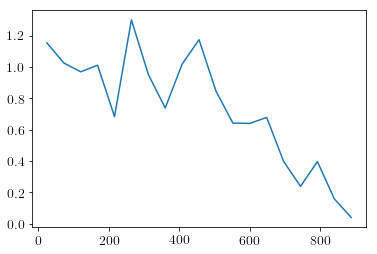

In [189]:
plt.plot(r[:-1],g)

## <font color=crimson>BASE $XY$ AND VORONOI FUNCTIONS</font>

In [6]:
# all code requires definition of 'npart' 

# READ POSITIONS FROM TEXT FILE generated from MD simulations
def read_xy(path, iframe):
    #nombre = 'hex_test/'+ str(npart)+'/rho0840/accel08/xyz'+ '{0:04d}'.format(iframe) +'.dat'
    nombre = path+'xyz'+ '{0:04d}'.format(iframe) +'.dat'
    # read using numpy:
    # xy = np.loadtxt(nombre, skiprows=1, usecols=(0,1))
    # read using pandas:
    xy = pd.read_table(nombre, skiprows=1, sep = '\s+', header=None,
                        usecols = [0,1], names=['x','y'], index_col=False)
    return xy

def average_xy(path,init_frame, end_frame):
    nframes = end_frame - init_frame + 1
    xy_av = read_xy(path, init_frame)
    for i in range(init_frame+1, end_frame+1):
        xy_av = xy_av + read_xy(path, i)
    xy_av = xy_av / nframes
    return xy_av
        
        
# FILTER OUTER CELLS, returns a numpy array
def inner_xy(xy,LX, X_off, LY, Y_off):
    return list(filter(lambda x: x[0] > X_off and x[1]>Y_off and x[0]<LX-X_off and x[1]<LY-Y_off,
                       [[xy[i][0], xy[i][1]] for i in range(npart)]))

#################################################################################
# Build INNER CELLS list. BEYOND THIS POINT USAGE REQUIRES vor=Voronoi(xy)   ####
#################################################################################


# OBTAINS cell vertices for ONE simulation PARTICLE, but ONLY for INNER cells
# INNER CELL DEFINITION: any cell with none of its vertexes within the border region
# USAGE: pseudo_cell(particle number, x size, x border, y size, y border)
# RETURNS an array of 2D lists (xy vertices positions) if all vertices are inner
# for outer cells returns VOID

def pseudo_cell_xy(vor,p_id, LX, X_off, LY, Y_off):
    b = vor.points[p_id]
    if b[0] < X_off or b[0] > LX-X_off or b[1] < Y_off or b[1] > LY - Y_off:
        c = []
    else:
        c = vor.vertices[vor.regions[vor.point_region[p_id]]]
        if np.any(c.T[0] < X_off) == True or np.any(c.T[0] > LX-X_off) or np.any(c.T[1] < Y_off) == True or np.any(c.T[1] > LY-Y_off):
            c = []
    return c

# OBTAINS THE ENTIRE LIST OF INNER CELLS
# USAGE: inner(particle_simulation_index, vertices_positions_2Dcoords_array)
# RETURNS a numpy array of objects: [particle number, [pseudo_cell_xy] ] with n_inner length
# INPUTS from pseudo_cell_xy, which inputs from Voronoi

def inner_cells(vor, LX, X_off, LY, Y_off):
    global n_inner
    inner = list(filter(lambda x: len(x[1])>3 ,
                          [ [i, pseudo_cell_xy(vor,i, LX, X_off, LY, Y_off)] for i in range(npart)]))
    n_inner = len(inner)
    return inner

#############################################################################################
#############################################################################################

def set_up_graf(idf, LX, LY):
    global ax, fig_system, ss

    fig_system = plt.figure(idf, figsize=(6.5,6.5))
    ss=(72./fig_system.dpi)**2
    ax = fig_system.add_subplot(1, 1, 1)
    ax.set_ylim([0,LX])
    ax.set_xlim([0,LY])
    ax.set_xlabel(r'$x$',fontsize = 20)
    ax.set_ylabel(r'$y$', fontsize = 20)

# TODO: graph simulation snapshot from above, with circles of size = sigma (particle diameter)
def graf_xy(xy, LX, LY):
    graf = ax.scatter(xy.x, xy.y, marker='o', lw=0, s=ss,c='k')

# GRAPHS FOR VORONOI TESSELLATION, only inner cells
# USAGE: graf_vor(inner), with inner a numpy array of inner_cells objects
# RETURNS 2 graphs
# INPUTS FROM inner_cells

def graf_vor(draw_cells, draw_edges, inner, LX, LY):
    
    global fig_cells, polygon_type
    
    # Build polygon type list
    polygon_type = [len(inner[i][1]) for i in range(n_inner)]
            
    # Build color list
    colors_built = ['w' for i in range(n_inner)]
    
    for i in range(len(inner)):
        if len(inner[i][1]) == 4:
            colors_built[i] = 'dodgerblue'
        elif len(inner[i][1]) == 5:
            colors_built[i] = 'mediumseagreen'
        elif len(inner[i][1]) == 6:
            colors_built[i] = 'lemonchiffon'
        elif len(inner[i][1]) == 7:
            colors_built[i] = 'tomato'  
        elif len(inner[i][1]) == 8:
            colors_built[i] = 'pink' 

    # old code
    #fig_cells, ax = plt.subplots(1, num=3, figsize=(9.5,9.5))
        
    # Build colored Tessellation
    # Draw Voronoi polygons
    if draw_cells>0:
        if draw_edges>0:
            lw = 0.1
        else:
            lw = 0
        col = PolyCollection([inner[i][1] for i in range(n_inner)],
                         linewidths=lw, facecolor= colors_built, alpha=0.5)
        col.set_edgecolors('k')
        graf = ax.add_collection(col)

##########################################
### POLYGON TYPE HISTOGRAM ###############
##########################################

    # bar plot the histogram
    #fig_hist, ax0 = plt.subplots(1, num=1, figsize=(7,7/ct.golden))
    
            
    # build distr. f of polygons
    #sides_distr = np.histogram(polygon_type, bins =np.arange(3,15) )
    #    
    #plt.xlim(np.min(polygon_type)-1,np.max(polygon_type)+1)
    #plt.ylim(0, 1.1*np.max(sides_distr[0]))
    #
    #plt.ylabel('$N$')
    #plt.xlabel('polygon')   

    ## Compute & Display ratio of hexagons
    #hex_ratio = sides_distr[0][3]/(1.*n_inner)
    ## define text box
    #plt.text(3.25, 1.0*np.max(sides_distr[0]), 'hexagons (\%): ' + '{:.2%}'.format(hex_ratio),
    #         size=12, ha="left", va="center",
    #         bbox=dict(boxstyle="round", ec=(1., 0.5, 0.5), fc=(1., 0.8, 0.8),)
    #         )
  
    #plt.bar(sides_distr[1][:-1], height=sides_distr[0], align='center')
    
##########################################


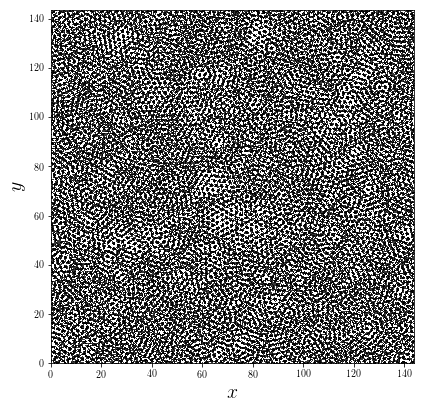

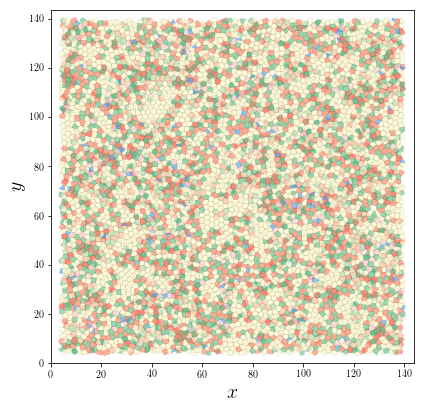

In [7]:
# CODIGO DE EJECUCION TESELACION DE VORONOI + GRAFICAS

base_path = '/home/fvega/Codigos/MD/hex_test/5000/rho0840/'
#base_path = '/home/fvega/Documentos/Apuntes/air_fluidized_exps/datos/'
#extra_path = 'hex_test/' + str(npart) + '/'
extra_path = 'accel1350/'

path = base_path + extra_path 

density = 0.840
npart = 5000
#xy = av_xy(800,990)
LX = L(npart, density) 
LY = LX

# The 3 previous lines allow for precise input of LX (if LX=LY)
X_off = 3 # this is the width of the border layer to discard
Y_off = X_off

#del fig_cells
set_up_graf(5, LX, LY)
for i in range(40):
    xy = read_xy(path, 950+i)
    grafxy = graf_xy(xy, LX, LY)

# Make Voronoi graph out of the last particle positions
vor = Voronoi(xy)
# Eliminate outer cells
inner = inner_cells(vor, LX=LX,X_off=X_off,LY=LX,Y_off=X_off)
# Represent particle positions and inner Voronoi cells
set_up_graf(6, LX, LY)
graf = graf_vor(1, 1,inner, LX, LX )

xy_av = average_xy(path,950,999)

# Make Voronoi graph out of average particle positions
vor = Voronoi(xy_av)
# Eliminate outer cells
inner = inner_cells(vor, LX=LX,X_off=X_off,LY=LX,Y_off=X_off)

# Superimpose 
graf = graf_vor(1, 1,inner, LX, LX )

In [ ]:
%%time

nrbin = 10000
r, g = gr(nrbin)
plt.plot(r, g, 'bo', markersize=0.6125)
plt.figure()
plt.xlim(0,20)
plt.plot(r, g, 'bo', markersize=1.25)

In [ ]:
#####################################################
######### XY 2D-STRUCTURE BASE FUNCTIONS  ###########
#####################################################
# return 2D XY-bin size (dxbin, dybin)
def make_xy_bins(nxbin, nybin):
    global dxbin, dybin, rmax
    # set init BINS MATRIX
    rho = np.zeros((nxbin,nybin))
    dxbin = (LX-2*X_off)/nxbin
    dybin = (LY-2*Y_off)/nybin
    rmax = np.sqrt((nxbin*dxbin)**2 + (nybin*dybin)**2)


#####################################################
######### RADIAL STRUCTURE BASE FUNCTIONS ###########
#####################################################
# returns r-bin size (drbin)
def make_r_bins( nrbin):
    global drbin
    rho_r = np.zeros(nrbin)
    drbin = rmax/(1.0*nrbin)

    
#########################################################################
################       XY BINS FUNCTIONS            #####################
#########################################################################
# returns ixy 2D index for a particle position. used by rho
def get_particle_xy_bin(pos_xy, nxbin, nybin):
    global ii
    ii = np.zeros(2, dtype=int)
    ii[0] = int(np.floor((pos_xy[0]-X_off)/dxbin))
    ii[1] = int(np.floor((pos_xy[1]-Y_off)/dybin)) #outer particles have negative index
    if ii[0] < 0 or ii[0] >= nxbin or ii[1] < 0 or ii[1] >= nybin:
        ii[0] = -1; ii[1] = -1

# return XY particle bins: ixy[i] variable, 'i' being 
# loop only over inner particles
def rho_xy(npart, nxbin, nybin):
    global ixy, nxy
    #npart = len(xy)
    ixy = np.zeros((npart,2), dtype=int)
    nxy = np.zeros((nxbin, nybin), dtype=int)
    for i in range(npart):
        get_particle_xy_bin(xy.ix[i], nxbin, nybin)
        ixy[i] = (ii[0], ii[1]) # identify the xy bin
        if ii[0] >= 0 and ii[1] >= 0:
            nxy[ii[0]][ii[1]] = nxy[ii[0]][ii[1]] + 1 # xy bin population sum

#########################################################################
################            RADIAL BIN FUNCTIONS          ###############
#########################################################################
# XY BIN DISTANCE FUNCTION: obtains distance between square bins
# input: first xy bin, second xy bin (2 pairs of integer numbers)
def bd(ij, ijprime):
    return np.sqrt(((ij[0]-ijprime[0])*dxbin)**2 + ((ij[1]-ijprime[1])*dybin)**2)


# Obtain all r bins
# Relies on bin-distance function (bd)
# ij is the reference bin
def get_r_bin(ij, ijprime):
    global rbin
    rbin = int( np.floor(bd(ij, ijprime)/drbin))
    return int(rbin)

# counts the number of times (ahead) we find an r-bin in the xy matrix
# it aims to naturally normalize radial functions according to this number
# r-bins counts stored in:  #### nir[rbin]  ####
def r_bin_counts(nxbin, nybin, nrbin):
    global nir, rij
    # rij: variable storing the r-bin for each xy-bin pair 
    rij = np.zeros((nxbin, nybin, nxbin, nybin))
    # nir: variable storing the number of occurrences for each r-bin
    # it is used for normalization in r-functions
    nir = np.zeros(nrbin+1, dtype=int)
    snxbin = str(nxbin)
    for i in range(nxbin):
        for j in range(nybin):
            for jp in range(j+1,nybin): # if pair in the same row, just count cells ahead
                rij[i, j, i, jp] = get_r_bin((i, j), (i, jp))
                nir[rbin] = nir[rbin] + 1
            for ip in range(i+1,nxbin):
                for jp in range(nybin):
                    rij[i, j, ip, jp] = get_r_bin((i, j), (ip, jp))
                    nir[rbin] = nir[rbin] + 1
        printp('line ' + str(i+1) + ' of ' + snxbin + ' complete')
    if nir[0] == 0: 
        print('r-bin size too small, choose less r-bins')
        
# RADIAL DENSITY FUNCTION
# procedure is as follows:
# we iterate over xy-bins, which are in each case the density origin (rho(0))
# for each xy-bin, we iterate over the following bins in the matrix, 
# and update rho according to the total population of the iteration bin
# and its distance to current origin
def rho_r(nxbin, nybin, nrbin ):
    global rho, rho_p
    rho = np.zeros(nrbin)
    for i in range(nxbin):
        for j in range(nybin):
            for jp in range(j+1,nybin): # if pair in the same row, just count cells ahead
                rbin = int(rij[i, j, i, jp])
                #print(rbin)
                rho[rbin] = rho[rbin] + nxy[i,jp]
            for ip in range(i+1,nxbin):
                for jp in range(nybin):
                    rbin = int(rij[i, j, ip, jp])
                    rho[rbin] = rho[rbin] + nxy[ip,jp]

    # normalize density
    for i in range(nrbin):
        rho[i] = rho[i]/nir[i]


In [ ]:
################################
# Build NEIGHBORS LIST #########
################################
def neighbor_cells(iframe):
    Voronoi_inner(iframe)
    neighbors = [[] for i in range(npart)]
    print('no. of inner particles: ', n_inner)
    for k in range(n_inner):
        part = inner[k][0]
        # cn: coordination no. of current particle (= the number of vertices in its cell)
        cn = len(vor.regions[vor.point_region[part]])
        # list of vertices for current particle
        verts = vor.regions[vor.point_region[part]]
        # initialize list  (raw_neighbors) of lists (raw_neighbors[i])
        # sublists will end up being the list of vertices in the cell of the repeated vertex
        raw_neighbors = [[] for i in range(cn)]
    
        # for each vertex, search its repetitions in the other cells, but only in inner ones
        for j in range(cn):
            # a closest neighbor is defined as a particle that has a common a cell vertex with the ref. part.
            raw_neighbors[j]=list(filter(lambda x: any(np.array(vor.regions[vor.point_region[x]]) == verts[j])
                                     , [inner[i][0] for i in range(n_inner)] ))
        # (each raw_neighbors is now the list of particles whose cell contains current vertex)
    
        # collapse into a single list
        for j in range(1,cn):
            raw_neighbors[0]+=raw_neighbors[j]
        # filter out self-repetitions
        raw_neighbors[0]= list(filter(lambda x: x != part, raw_neighbors[0]))
        # remove duplicates from shared vertices among neighbor cells (set) and sort (sorted)  
        neighbors[part] = sorted(np.array(list(set(raw_neighbors[0]))))
        if k%100==0: printp('iteracion: ' + str(k))


In [ ]:
# ORIENTATIONAL CORRELATION FUNCTION


psi = np.zeros((nxbin, nybin)) # initialize psi matrix

for i in range(len(inner)):
    part = inner[i][0]
    icn = 1./len(neighbors[part]) 
    xyk = vor.points[part]
    rk = np.linalg.norm(xyk)
    
    xbin = int(np.floor(xyk[0]/dbin))
    ybin = int(np.floor(xyk[1]/dbin))
    
    # k is the reference particle, j is the neighbor
    for j in range(cn):
        xyj = vor.points[neighbors[part][j]]
        rj= np.linalg.norm(xyj)
        thetajk = np.arccos(np.dot(xyk,xyj)/(rj*rk))
        psi[xbin][ybin] += (np.exp(thetajk*6j)*icn)